In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import scipy.optimize, scipy.stats as stats, pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, adfuller, acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
data = pd.read_csv('global.csv')

In [3]:
def s(t, A, w, p, c ):
  return A*np.sin(w*t +p) + c

In [4]:
def sampleACVF(X, h):
    n = len(X)
    x_mean = np.mean(X)
    return 1/n*sum((X[i]-x_mean)*(X[i+abs(h)]-x_mean) for i in range(1,n-abs(h)))
def sampleACF(X, h):
    return sampleACVF(X, h)/sampleACVF(X, 0)

In [5]:
def fit_sin(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

## Aleksandria (ten gigantyczny zbiór danych)

In [6]:
data['City'].unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome', 'São Paulo',
       'S

In [7]:
alexandria = data[data['City'] == 'Alexandria']
al = alexandria['AverageTemperature'][-481:-1]
t = np.linspace(1973.75, 2013.75, 480)
alexandria["dt"][-481:-480]

11412    1973-09-01
Name: dt, dtype: object

Text(0.5, 1.0, 'Surowe dane, Aleksandria 1973-2013')

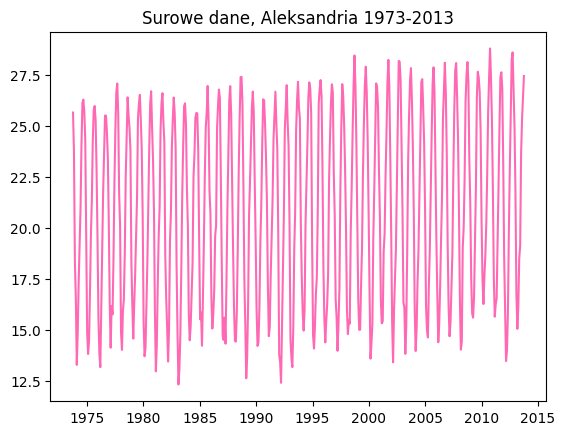

In [8]:
plt.plot(t, al, color = 'hotpink')
plt.title('Surowe dane, Aleksandria 1973-2013')

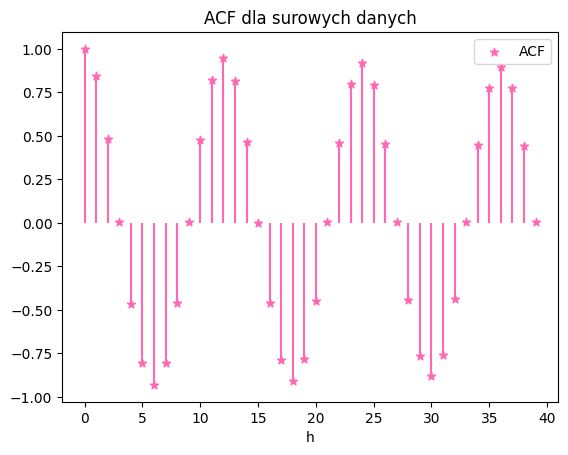

In [9]:
hs = np.arange(40)
acc = [sampleACF(np.array(al), h) for h in hs]
plt.vlines(x=hs, ymin=0, ymax=acc, color = 'hotpink')
plt.scatter(hs, acc, marker = '*', color = 'hotpink', label = 'ACF')
plt.title('ACF dla surowych danych'); plt.legend()
plt.xlabel('h')
plt.savefig('surowe_acf.png')

Text(0.5, 0, 'h')

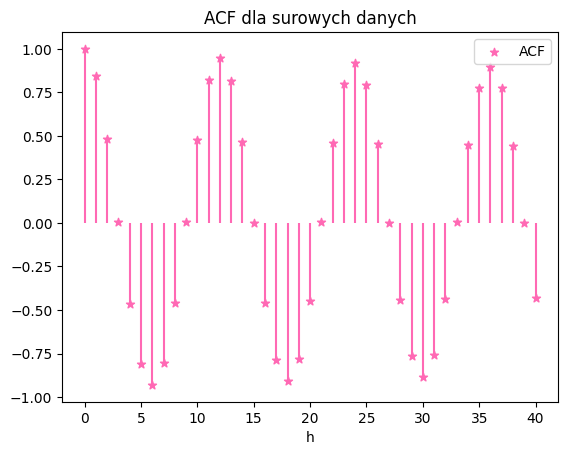

In [10]:
hs1 = np.arange(41)
acf_, confint = acf(np.array(al), nlags=40, alpha=0.05)
# c1, c2 = np.array([p[0] for p in confint]), np.array([p[1] for p in confint])
# plt.fill_between(hs1, c1, c2, color = 'darkseagreen')
plt.vlines(x=hs1, ymin=0, ymax=acf_, color = 'hotpink')
plt.scatter(hs1, acf_, marker = '*', color = 'hotpink', label = "ACF")
plt.title('ACF dla surowych danych'); plt.legend(loc = 'best')
plt.xlabel('h')

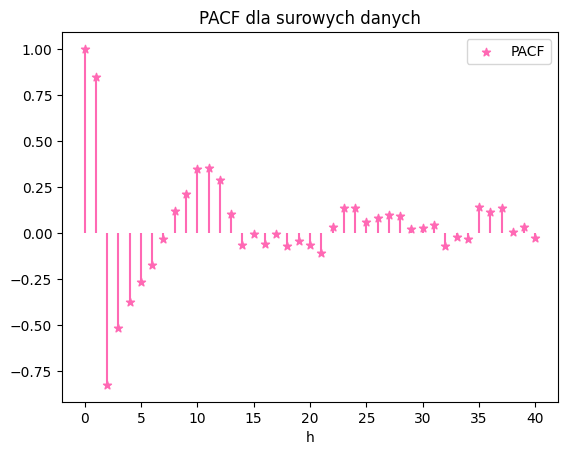

In [11]:
pacf_, confint = pacf(np.array(al), nlags=40, method='ld', alpha=0.05)
# c1, c2 = np.array([p[0] for p in confint]), np.array([p[1] for p in confint])
# plt.fill_between(hs1, c1, c2, color = 'darkseagreen')
plt.vlines(x=hs1, ymin=0, ymax=pacf_, color = 'hotpink')
plt.scatter(hs1, pacf_, marker = '*', color = 'hotpink', label = 'PACF')
plt.title('PACF dla surowych danych'); plt.legend()
plt.xlabel('h')
plt.savefig('surowe_pacf.png')

-55.3200 + 0.0382*t


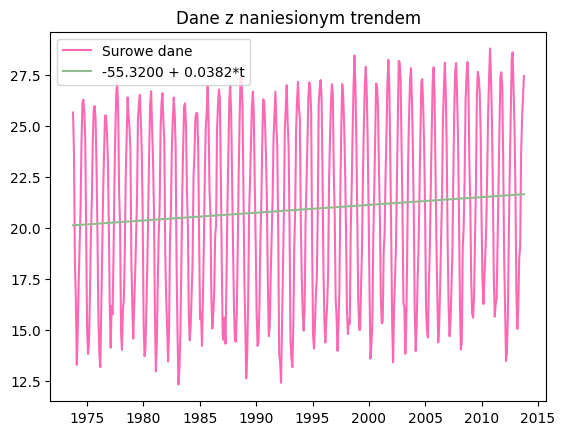

In [12]:
def oblicz_regresje(x, y):
    b1 = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x))**2)
    b0 = np.mean(y) - b1 * np.mean(x)
    return b0, b1

b0, b1 = oblicz_regresje(t, al)
trend = b1*t + b0
plt.plot(t, al, color = 'hotpink', label = 'Surowe dane')
plt.plot(t, trend, label = f'{b0:.4f} + {b1:.4f}*t', color = 'darkseagreen')
plt.title('Dane z naniesionym trendem'); plt.legend()
plt.savefig('daneItrend.png')
print(f'{b0:.4f} + {b1:.4f}*t')

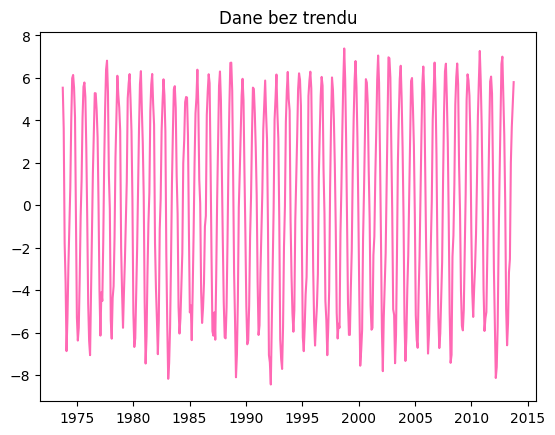

In [13]:
X_star = al - trend
plt.plot(t, X_star, color = 'hotpink'); plt.title('Dane bez trendu')
plt.savefig('dane_bez_trendu.png')

C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


6.3869sin(6.2693t + 6.1977)


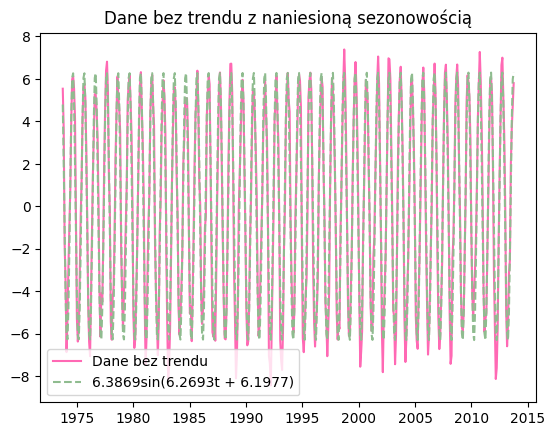

In [14]:
fit = fit_sin(t, X_star) 
A, omega, phase, offset = fit['amp'], fit['omega'], fit['phase'], fit['offset']
X2 = X_star - s(t, A, omega, phase, offset)
X3 = np.array(X2)
plt.plot(t, X_star, label = 'Dane bez trendu', color = 'hotpink')
plt.plot(t, s(t, A, omega, phase, offset), label = f'{A:.4f}sin({omega:.4f}t + {phase:.4f})', ls = '--', color = 'darkseagreen'); plt.legend()
plt.title('Dane bez trendu z naniesioną sezonowością')
plt.savefig('sezonowosc.png')
print(f'{A:.4f}sin({omega:.4f}t + {phase:.4f})')

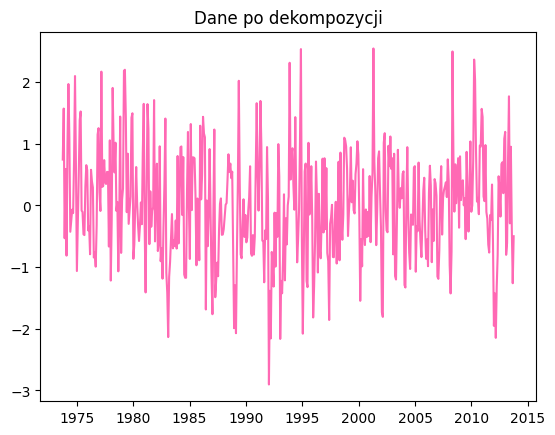

In [15]:
plt.plot(t, X2, label = 'Przekształcone dane', color = 'hotpink')
plt.title('Dane po dekompozycji')
plt.savefig('final_decomposed.png')

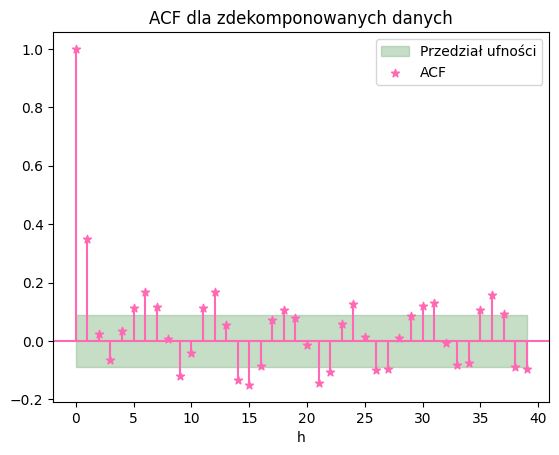

In [16]:
z_alpha = stats.norm.ppf(1 - 0.05 / 2)  # Z wartość dla 95% ufności
c12 = z_alpha * np.sqrt(1 / 480)  # Symetryczne przedziały
acf_final = [sampleACF(np.array(X2), h) for h in hs]
plt.fill_between(hs, c12, -c12, color = 'darkseagreen', alpha = 0.5, label = 'Przedział ufności')
plt.vlines(x=hs, ymin=0, ymax=acf_final, color = 'hotpink')
plt.axhline(y = 0, color = 'hotpink')
plt.scatter(hs, acf_final, marker = '*', color = 'hotpink', label = 'ACF')
plt.title('ACF dla zdekomponowanych danych'); plt.legend()
plt.xlabel('h')
plt.savefig('decomposed_acf.png')

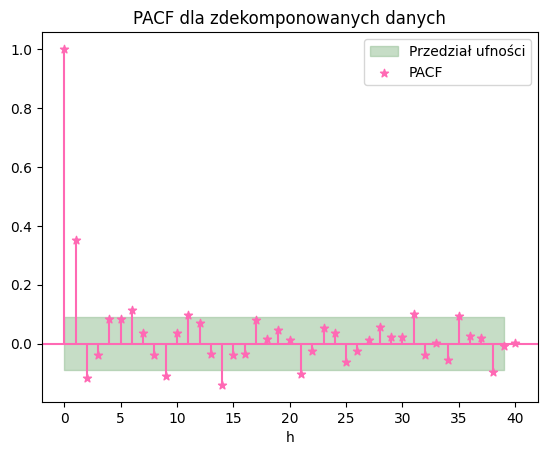

In [17]:
pacf_, confint = pacf(np.array(X2), nlags=40, method='ld', alpha=0.05)
# c1, c2 = np.array([p[0] for p in confint]), np.array([p[1] for p in confint])
# plt.fill_between(hs1, c1, c2, color = 'darkseagreen')
plt.fill_between(hs, c12, -c12, color = 'darkseagreen', alpha = 0.5, label = 'Przedział ufności')
plt.vlines(x=hs1, ymin=0, ymax=pacf_, color = 'hotpink')
plt.axhline(y = 0, color = 'hotpink')
plt.scatter(hs1, pacf_, marker = '*', color = 'hotpink', label = 'PACF')
plt.title('PACF dla zdekomponowanych danych'); plt.legend()
plt.xlabel('h')
plt.savefig('decomposed_pacf.png')

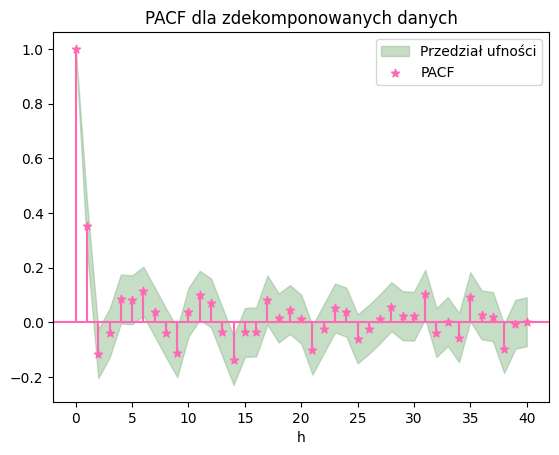

In [18]:
pacf_2, confint_p = pacf(X3, nlags=40, method='ld', alpha=0.05)
c1, c2 = np.array([p[0] for p in confint_p]), np.array([p[1] for p in confint_p])
plt.fill_between(hs1, c1, c2, color = 'darkseagreen', alpha = 0.5, label = 'Przedział ufności')
# plt.fill_between(hs, c12, -c12, color = 'darkseagreen')
plt.vlines(x=hs1, ymin=0, ymax=pacf_2, color = 'hotpink')
plt.axhline(y = 0, color = 'hotpink')
plt.scatter(hs1, pacf_2, marker = '*', color = 'hotpink', label = 'PACF')
plt.title('PACF dla zdekomponowanych danych'); plt.legend()
plt.xlabel('h')
plt.savefig('przedział_pacf.png')

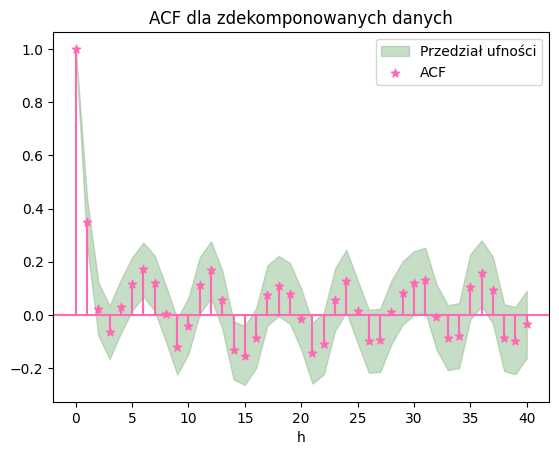

In [19]:
acf_2, confint_a = acf(X3, nlags=40, alpha=0.05)
c11, c22 = np.array([p[0] for p in confint_a]), np.array([p[1] for p in confint_a])
plt.fill_between(hs1, c11, c22, color = 'darkseagreen', alpha = 0.5, label = 'Przedział ufności')
plt.vlines(x=hs1, ymin=0, ymax=acf_2, color = 'hotpink')
plt.axhline(y=0, color = 'hotpink')
plt.scatter(hs1, acf_2, marker = '*', color = 'hotpink', label = "ACF")
plt.title('ACF dla zdekomponowanych danych'); plt.legend(loc = 'best')
plt.xlabel('h')
plt.savefig('przedzial_acf.png')


In [20]:
# Testowanie stacjonarności
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

adfuller_test(X3)

Statystyka testowa = -5.571, p-Value = 0.0 => Stationary. 


In [35]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(alexandria, explorative=True)
# profile.to_file("EDA4_pandas-profiling_report.html")
# import sweetviz as sv
# sweet_report = sv.analyze(alexandria)
# sweet_report.show_html('EDA4_sweetviz.html')
# plt.rcdefaults()

## Dobranie rzeędu modelu

In [36]:
data = X2

df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 5
max_q = 5

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(data, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Py

In [37]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
17,3,2,1131.553505,1160.770007,1143.037876
14,2,4,1135.670210,1169.060499,1148.795207
18,3,3,1136.926567,1170.316856,1150.051563
13,2,3,1136.963033,1166.179535,1148.447405
23,4,3,1138.475276,1176.039351,1153.240897


In [38]:
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
17,3,2,1131.553505,1160.770007,1143.037876
13,2,3,1136.963033,1166.179535,1148.447405
14,2,4,1135.670210,1169.060499,1148.795207
18,3,3,1136.926567,1170.316856,1150.051563
23,4,3,1138.475276,1176.039351,1153.240897


In [39]:
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
17,3,2,1131.553505,1160.770007,1143.037876
13,2,3,1136.963033,1166.179535,1148.447405
14,2,4,1135.670210,1169.060499,1148.795207
18,3,3,1136.926567,1170.316856,1150.051563
23,4,3,1138.475276,1176.039351,1153.240897


## estymacja parametrów

In [23]:
p, q = 3, 2

model3 = ARIMA(X2, order=(p, 0, q)).fit()
print(model3.summary())

C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                  480
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -558.777
Date:                Mon, 27 Jan 2025   AIC                           1131.554
Time:                        23:48:51   BIC                           1160.770
Sample:                             0   HQIC                          1143.038
                                - 480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.053     -0.034      0.973      -0.105       0.102
ar.L1          1.3295      0.044     30.181      0.000       1.243       1.416
ar.L2         -1.3309      0.044    -30.272      0.0

C:\Users\Maria Nowacka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Maria Nowacka\AppData\Local\Temp\ipykernel_10536\240054425.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(params3[1:-1], '.',marker = '*', markersize=10, alpha=0.5, label = 'predicted', color = 'hotpink')


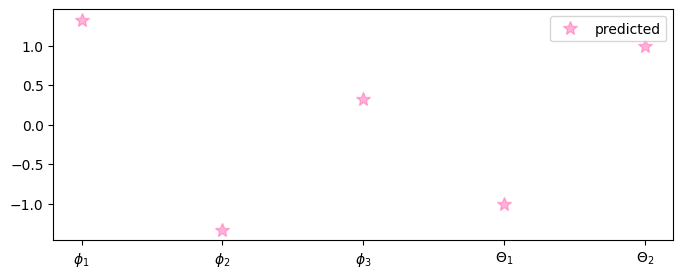

In [24]:
resid3 = model3.resid
params3 = model3.params
plt.figure(figsize=(8,3))
# plt.plot([p1, p2, q1, q2], '.', markersize=10, alpha=0.5)
plt.plot(params3[1:-1], '.',marker = '*', markersize=10, alpha=0.5, label = 'predicted', color = 'hotpink')
# plt.legend(['true', 'predicted'])
plt.legend()
plt.xticks([0, 1, 2, 3, 4], ['$\phi_1$', '$\phi_2$', '$\phi_3$', '$\Theta_1$', '$\Theta_2$']);

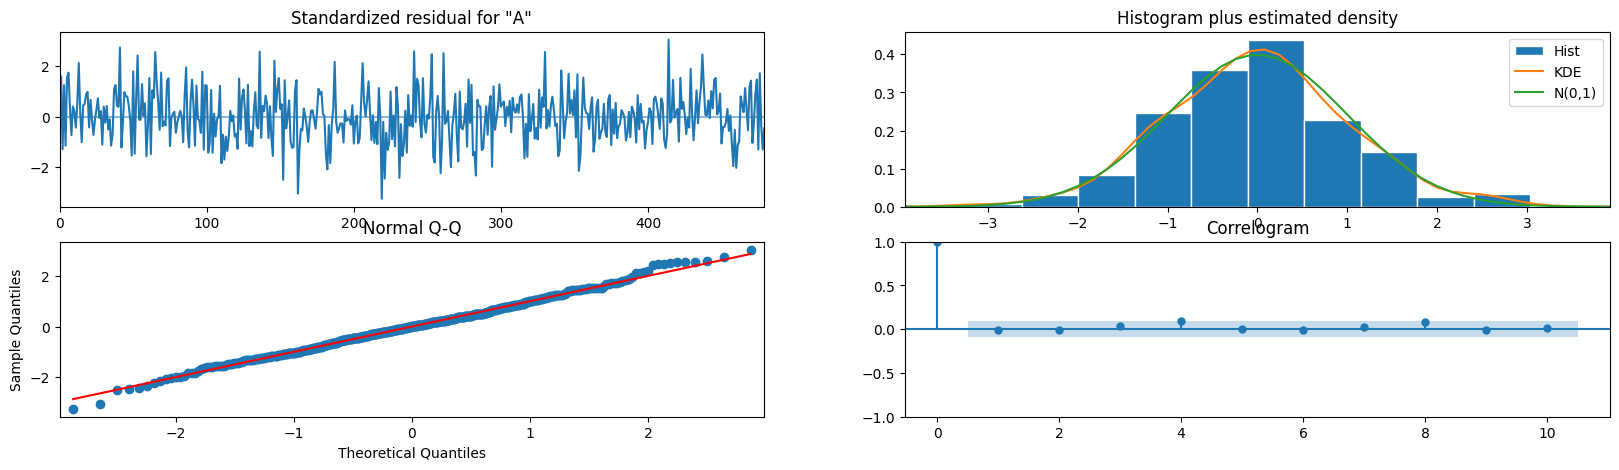

In [25]:
model3.plot_diagnostics(0,figsize=(20,5))
plt.plot();

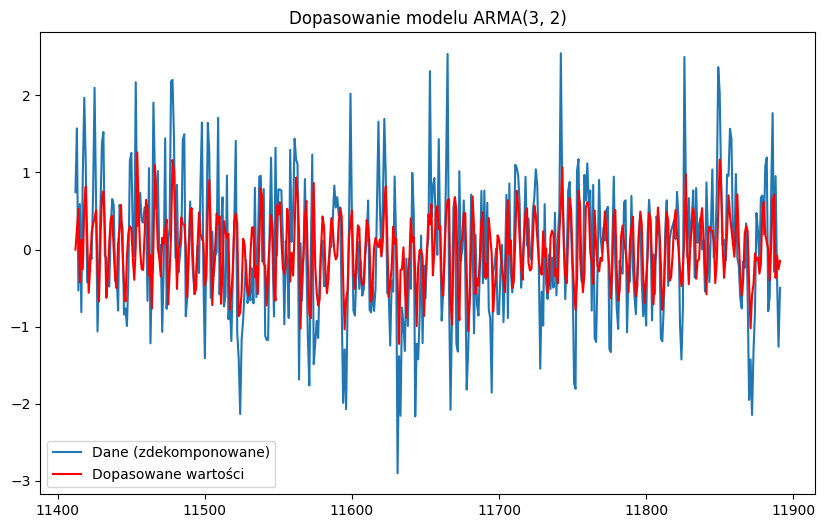

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(X2, label='Dane (zdekomponowane)')
plt.plot(model3.fittedvalues, label='Dopasowane wartości', color='red')
plt.legend()
plt.title('Dopasowanie modelu ARMA(3, 2)')
plt.show()

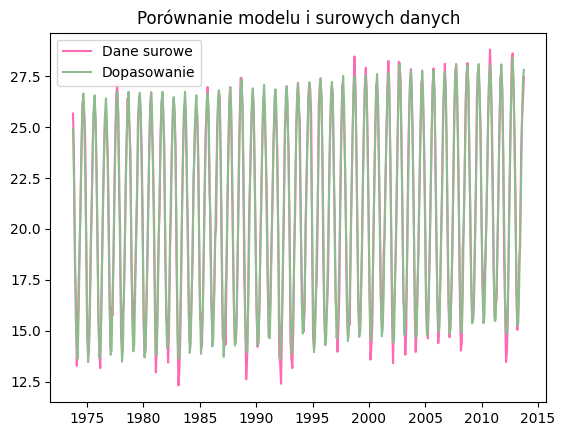

In [27]:
plt.plot(t, al, color = 'hotpink', label = 'Dane surowe')
plt.plot(t, model3.fittedvalues + s(t, A, omega, phase, offset) + b0 + b1*t, color = 'darkseagreen', label = 'Dopasowanie')
plt.title('Porównanie modelu i surowych danych'); plt.legend()
plt.savefig('3_2_final.png')

In [28]:
params3
[phi1_, phi2_, phi3_, theta1_, theta2_] = params3[1:-1]
phi1_, phi2_, phi3_, theta1_, theta2_

(1.3294901979849114,
 -1.330899499237904,
 0.33176736127690115,
 -1.003476675660714,
 0.9996826747588954)

## testy wizualne

[]

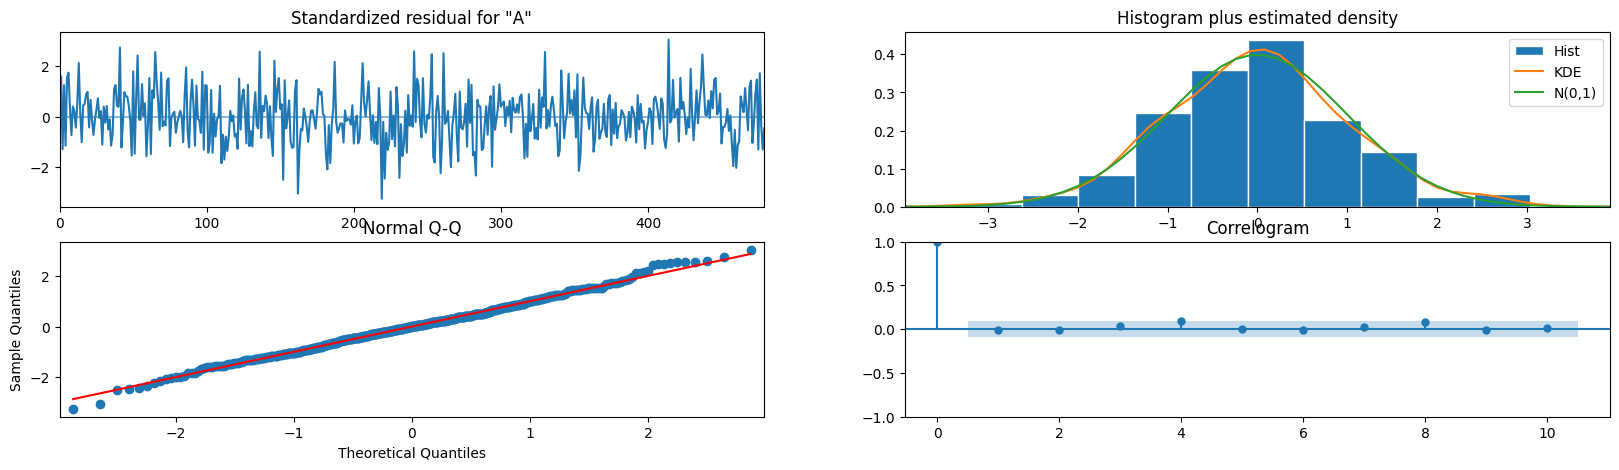

In [29]:
model3.plot_diagnostics(0,figsize=(20,5))
plt.plot()

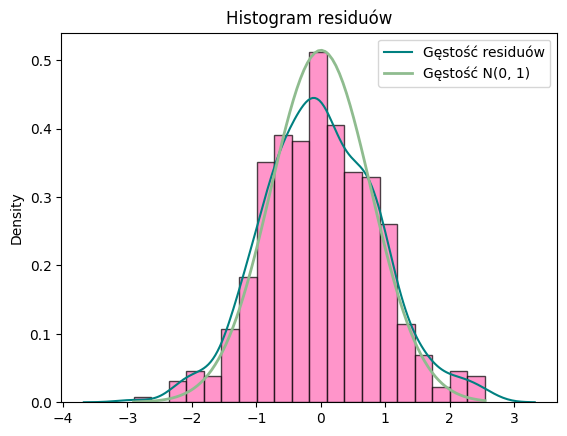

In [30]:
import seaborn as ssn
# import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm, probplot
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# axes = axes.flatten()
residuals3 = model3.resid
# 1. Histogram reszt z krzywą normalną
ssn.kdeplot(X3, color = 'teal', label = 'Gęstość residuów')
plt.hist(X3, bins=20, color='hotpink', edgecolor='black', density=True, alpha=0.7)
mu, std = norm.fit(residuals3)
x3 = np.linspace(min(X3), max(X3), 100)
p3 = norm.pdf(x3, mu, std)
plt.plot(x3, p3, color = 'darkseagreen', linewidth=2, label='Gęstość N(0, 1)')
plt.title("Histogram residuów")
plt.legend()
plt.savefig('norm3X3.png')
plt.show()

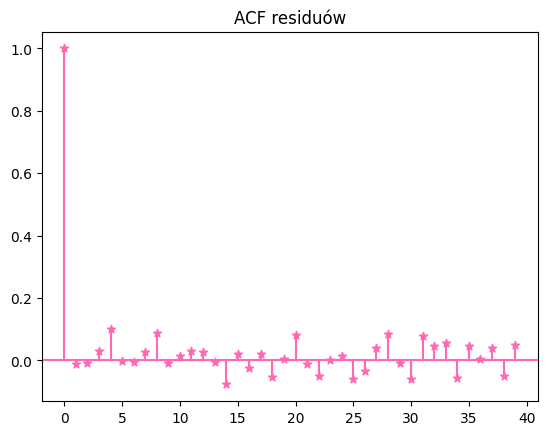

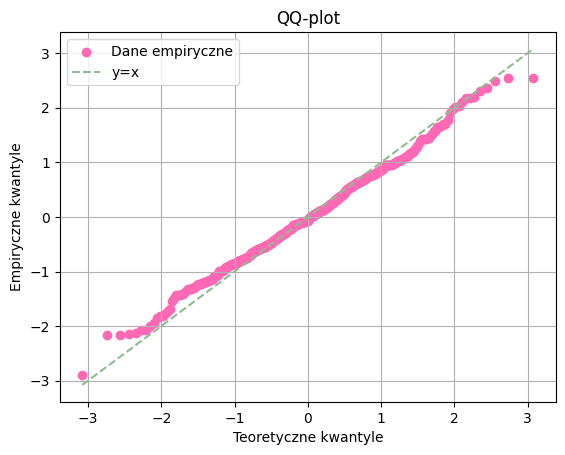

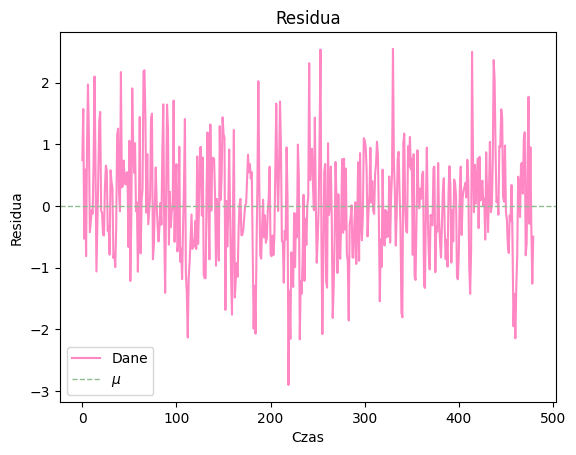

In [31]:

# 2. Autokorelacja reszt (ACF)
# plot_acf(residuals, ax=axes[1], lags=20, color='hotpink', title="ACF of Residuals")
autocov3 = [sampleACF(np.array(residuals3), h) for h in hs]
plt.scatter(hs, autocov3, marker = '*', color = 'hotpink')
plt.vlines(x=hs, ymin=0, ymax=autocov3, color = 'hotpink')
plt.axhline(y = 0, color = 'hotpink')
plt.title('ACF residuów')
plt.savefig('resid3_acf.png')
plt.show()
# 3. QQ-Plot
data = X2
data_sorted = np.sort(data)
n = len(data)
quantile_positions = (np.arange(1, n + 1) - 0.5) / n
theoretical_quantiles = stats.norm.ppf(quantile_positions)
# plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, data_sorted, color="hotpink", label="Dane empiryczne")
plt.plot(theoretical_quantiles, theoretical_quantiles, color="darkseagreen", label="y=x", linestyle="--")
plt.xlabel("Teoretyczne kwantyle")
plt.ylabel("Empiryczne kwantyle")
plt.title("QQ-plot")
plt.legend()
plt.grid()
plt.savefig('qqplot.png')
plt.show()
# 4. Wykres reszt w czasie
plt.plot(X3, color='hotpink', linestyle='-', alpha=0.8, label = 'Dane')
plt.axhline(np.mean(X3), linestyle='--', color='darkseagreen', linewidth=1, label = r'$\mu$')
plt.title("Residua"); plt.legend()
plt.xlabel("Czas")
plt.ylabel("Residua")
plt.savefig('residuals3.png')



### testy statystyczne

In [32]:
ljung_box_result = acorr_ljungbox(resid3, lags=[10], return_df=True)

print(ljung_box_result,'\nCzy reszty są niezależne? Jeśli p_value > 0.05 to tak.')

    lb_stat  lb_pvalue
10  9.30411   0.503506 
Czy reszty są niezależne? Jeśli p_value > 0.05 to tak.


In [33]:
# średnia
from scipy.stats import ttest_1samp, chi2

t_stat, p_value = ttest_1samp(X3, popmean=0)
print(f"t-statistic: {t_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("\nOdrzucamy hipotezę zerową. Średnia różni się od wartości oczekiwanej.")
else:
    print("\nBrak podstaw do odrzucenia hipotezy zerowej. Średnia nie różni się istotnie od wartości oczekiwanej.")

# wariancja arch test
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

lags = 10
arch_test = het_arch(X3, nlags=lags)

# Wyniki testu
lm_stat = arch_test[0]  # Statystyka testu LM
lm_pvalue = arch_test[1]  # p-wartość dla statystyki LM
f_stat = arch_test[2]  # Statystyka testu F
f_pvalue = arch_test[3]  # p-wartość dla statystyki F

print(f"Lagrange Multiplier Test Statistic: {lm_stat}")
print(f"LM Test p-value: {lm_pvalue}")
print(f"F-Test Statistic: {f_stat}")
print(f"F-Test p-value: {f_pvalue}")

if lm_pvalue < 0.05:
    print("Odrzucamy hipotezę zerową: Efekt ARCH jest obecny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej: Brak efektu ARCH.")


t-statistic: 0.019071340621541755, p-value: 0.9847921354320044

Brak podstaw do odrzucenia hipotezy zerowej. Średnia nie różni się istotnie od wartości oczekiwanej.
Lagrange Multiplier Test Statistic: 16.76695795645801
LM Test p-value: 0.07968229620638863
F-Test Statistic: 1.6980301496365462
F-Test p-value: 0.07848236817609255
Brak podstaw do odrzucenia hipotezy zerowej: Brak efektu ARCH.


In [34]:
# normalność
stats.shapiro(X3)

ShapiroResult(statistic=0.9958302974700928, pvalue=0.23462893068790436)

In [35]:
np.mean(residuals3), np.mean(X3), np.var(residuals3), np.var(X3)

(0.0024955671834104632,
 0.0007688935697969394,
 0.6012726259162039,
 0.7785840911837721)

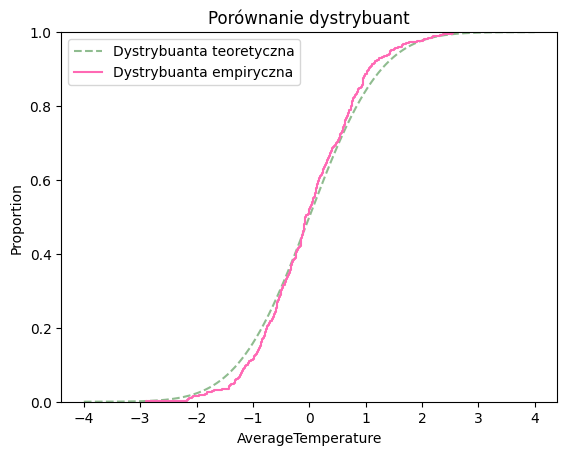

In [36]:
x = np.linspace(-4, 4, 500)
plt.plot(x, norm.cdf(x, 0, 1), label = 'Dystrybuanta teoretyczna', color = 'darkseagreen', ls = '--')
ssn.ecdfplot(data = X2, label = 'Dystrybuanta empiryczna', color = 'hotpink')
plt.legend(); plt.title('Porównanie dystrybuant')
plt.savefig('cdf.png')

In [37]:
# linie kwantylowe
from statsmodels.tsa.arima_process import ArmaProcess
quan = [0.05, 0.25, 0.5, 0.75, 0.95]
ar_coef, ma_coef = [phi1_, phi2_, phi3_], [theta1_, theta2_]
MC = 5000
n = 480
A = np.array([ArmaProcess(ar_coef, ma_coef).generate_sample(nsample=480, scale=2) for _ in range(MC)])
# q95 = np.quantile(A, 0.95, axis = 0)
# q5 = np.quantile(A, 0.05, axis = 0)
quantiles_emp = [np.quantile(A, qq, axis = 0) for qq in quan]


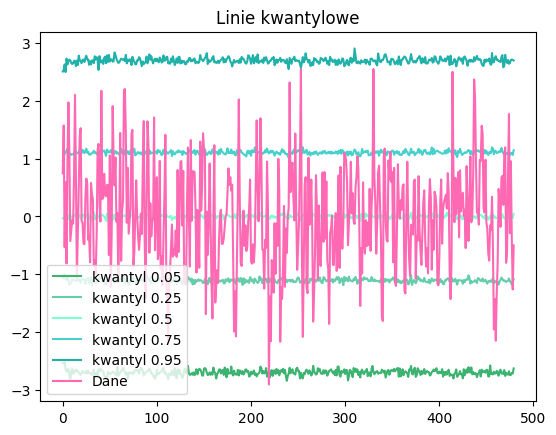

In [38]:
# quantiles_theoretical = norm.ppf()
colors = ['mediumseagreen', 'mediumaquamarine', 'aquamarine', 'mediumturquoise', 'lightseagreen']
for i,c in enumerate(quantiles_emp):
    plt.plot(np.arange(480),quantiles_emp[i], color = colors[i], label = f'kwantyl {quan[i]}')
plt.plot(X3, color = 'hotpink', label = "Dane")
plt.legend(); plt.title('Linie kwantylowe')
plt.savefig('liniekwaantylowe.png')